In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primaldual_PINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

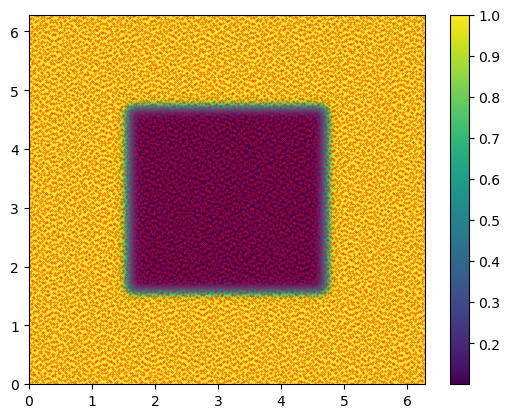

In [3]:
L = 2*np.pi
N = 1024 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    eps = 10
    x_dir = 0.5 + 0.5*np.tanh(eps*np.sin(x-np.pi/2))
    y_dir = 0.5 + 0.5*np.tanh(eps*np.sin(y-np.pi/2))
    a = 1 - 0.9*x_dir*y_dir
    return a

def A_interp(x):  
    eps = 10
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

In [4]:
net = PINN_2(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN_double/square/PINN_double_{total_params}'}

Number of parameters: 130


In [5]:
net = load_network(net, args['name']+'_39999', args)
net = net.to(dev)

In [36]:
losses_train, losses_val = train(net, loaders, args, A_interp, H1, L, 0.01)

Epoch: 0 mean train loss:  4.07930791e-01, mean val. loss:  9.93051112e-01
Epoch: 1 mean train loss:  4.09800708e-01, mean val. loss:  9.93702352e-01
Epoch: 2 mean train loss:  4.08104688e-01, mean val. loss:  9.91935849e-01
Epoch: 3 mean train loss:  4.09492552e-01, mean val. loss:  9.91922021e-01
Epoch: 4 mean train loss:  4.08665180e-01, mean val. loss:  9.92941201e-01
Epoch: 5 mean train loss:  4.07980293e-01, mean val. loss:  9.93879855e-01
Epoch: 6 mean train loss:  4.08428043e-01, mean val. loss:  9.94213462e-01
Epoch: 7 mean train loss:  4.08726722e-01, mean val. loss:  9.93845522e-01
Epoch: 8 mean train loss:  4.08341855e-01, mean val. loss:  9.93084669e-01
Epoch: 9 mean train loss:  4.07973856e-01, mean val. loss:  9.92355943e-01
Epoch: 10 mean train loss:  4.08095568e-01, mean val. loss:  9.91973877e-01
Epoch: 11 mean train loss:  4.08356577e-01, mean val. loss:  9.92063463e-01
Epoch: 12 mean train loss:  4.08279508e-01, mean val. loss:  9.92533922e-01
Epoch: 13 mean train l

In [41]:
np.save(f'NN_library/training_data/square/PINN_double_{total_params}_1', np.vstack([losses_train, losses_val]))

In [ ]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [7]:
U = net(grid_data).detach().cpu()
pde_p1, pde_d1, _, _ = PDE_loss_primal_dual(grid_data, net, A_interp, H1)
pde_p2, pde_d2, _, _ = PDE_loss_primal_dual(grid_data, net, A, H1)

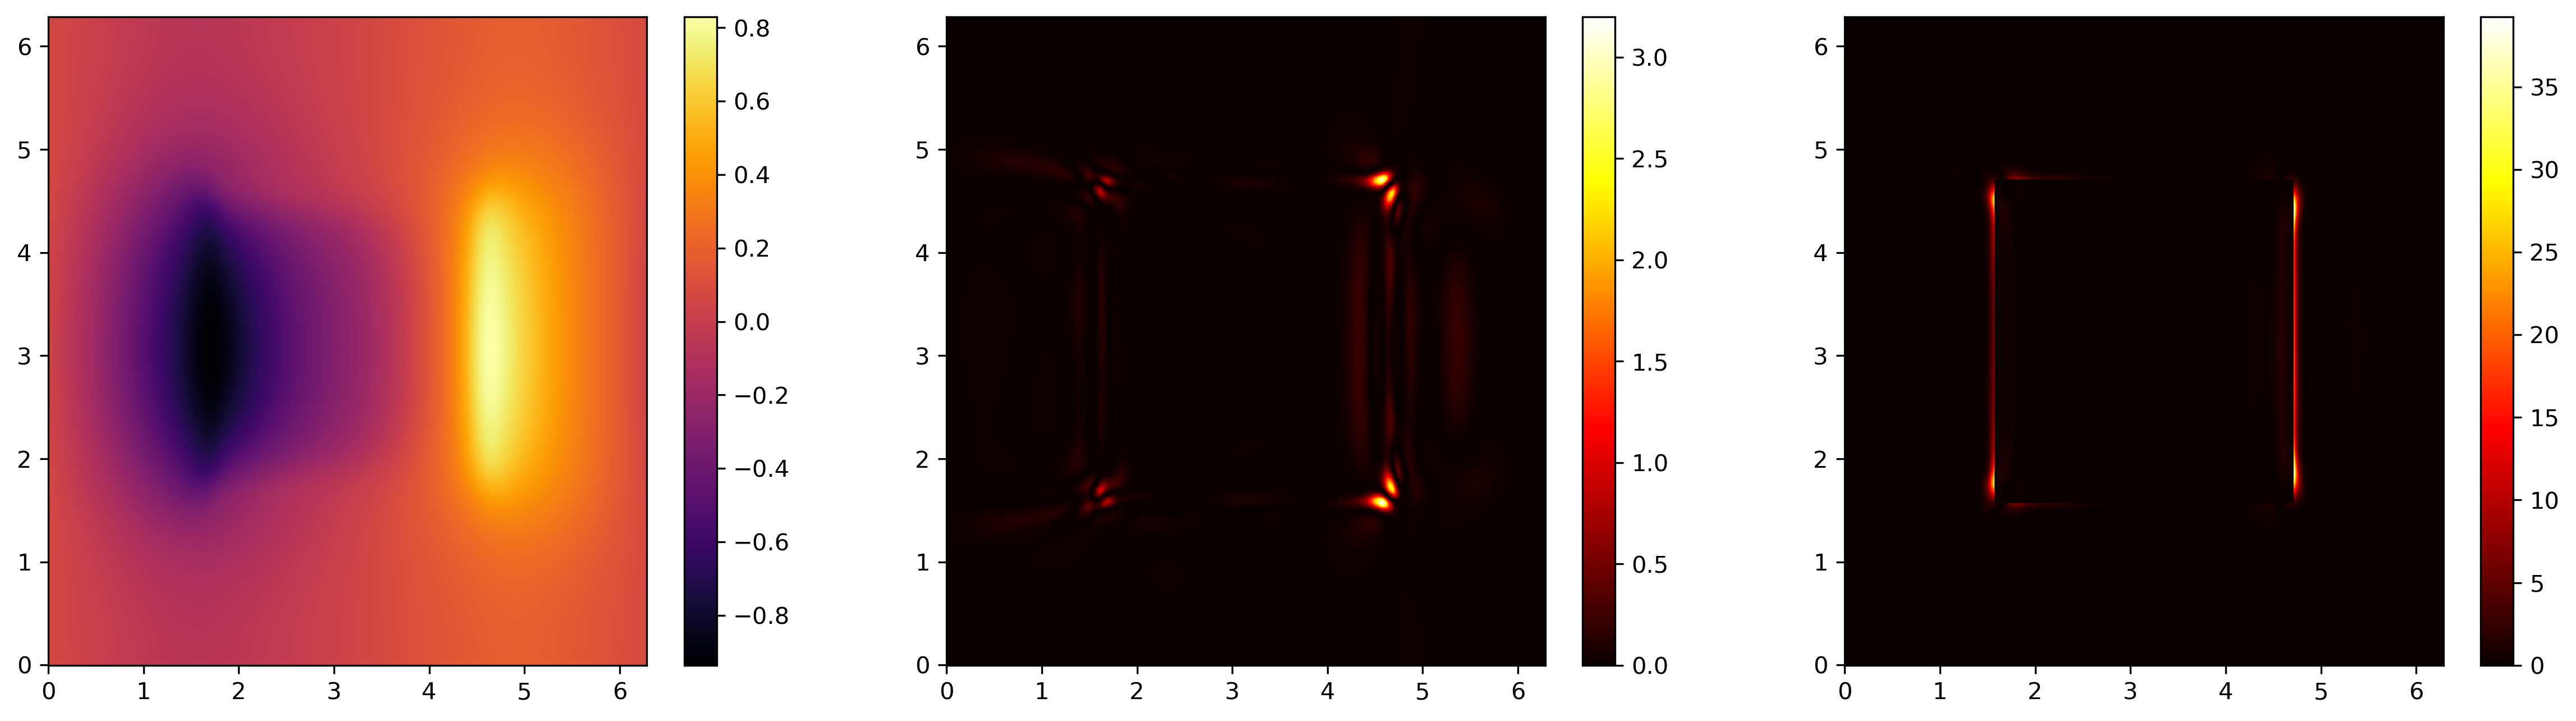

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,0].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], pde_p1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], pde_p2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

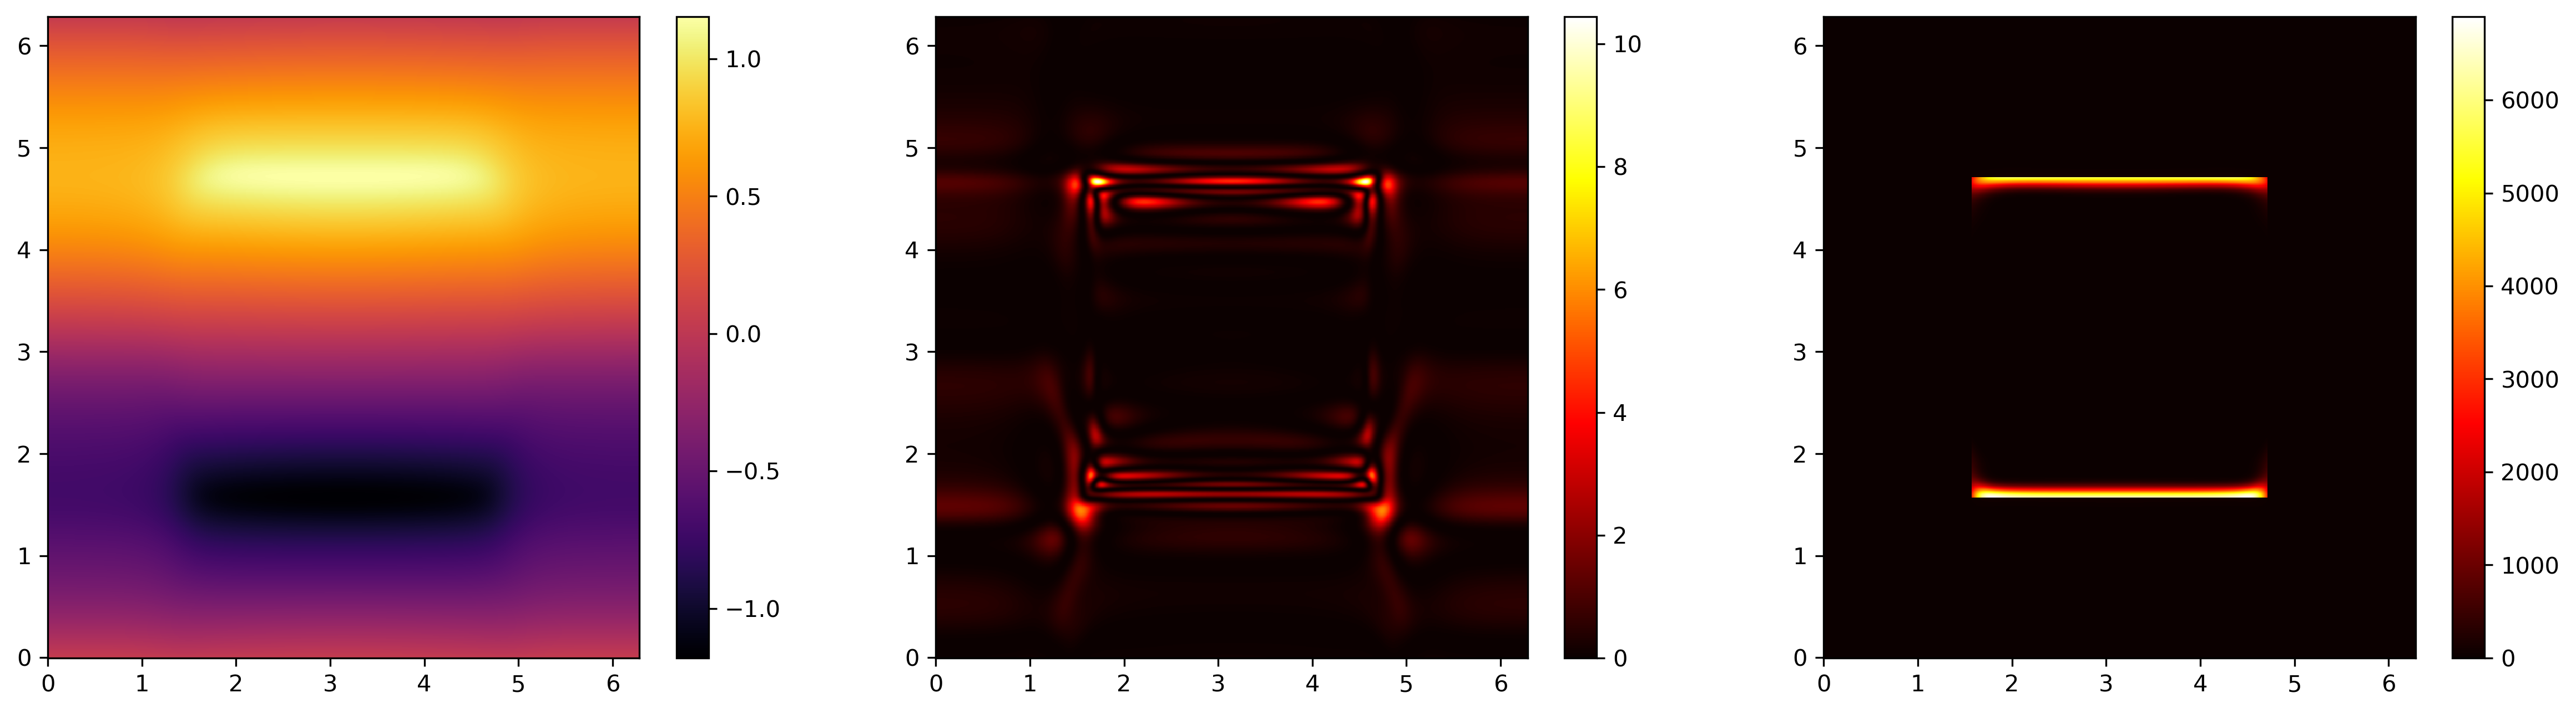

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,1].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], pde_d1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], pde_d2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [10]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, _, q_p1, q_d1 = PDE_loss_primal_dual(x, net, A_interp, H1)
_, _, q_p2, q_d2 = PDE_loss_primal_dual(x, net, A, H1)
bound_u_1 = compute_bound(areas, tri, q_p1, L).detach()
bound_u_2 = compute_bound(areas, tri, q_p2, L).detach()
bound_l_1 = compute_bound(areas, tri, q_d1, L).detach()
bound_l_2 = compute_bound(areas, tri, q_d2, L).detach()
bound_inv_1 = bound_l_1[0] / (bound_l_1[0]**2 - bound_l_1[1]**2)
bound_inv_2 = bound_l_2[0] / (bound_l_2[0]**2 - bound_l_2[1]**2)

print(bound_u_1[0], bound_u_2[0])
print(bound_inv_1, bound_inv_2)
np.save(f'bounds/square/A_u_PINN_double_{total_params}.npy', (bound_u_1[0].item(), bound_u_2[0].item()))
np.save(f'bounds/square/A_l_PINN_double_{total_params}.npy', (bound_inv_1.item(), bound_inv_2.item()))

tensor(0.6739, device='cuda:0') tensor(0.6714, device='cuda:0')
tensor(0.6740, device='cuda:0') tensor(0.6178, device='cuda:0')
